# Pseudo Elliptical Lenses

Pseudo-elliptical lenses are generally referred as lenses generated by ellipticizing the lensing potential rather than the surface density distribution.
In other words:

$$
\psi(\vec x)=\psi(\sqrt{x_1^2+f^2x_2^2})
$$

The great advantage of dealing with the potential is that all lens properties can be derived more easily by means of its derivatives. 

We may try to build an elliptical softened isothermal sphere using this approach:

* we start from the lensing potential of the NIS$_\psi$ and make the iso-potential contours elliptical:
$$
\psi(\vec x)=\sqrt{x_1^2+f^2x_2^2+x_c^2}
$$
* then, we compute the deflection field as the gradient of $\psi$
$$
\vec\alpha=\vec\nabla\psi(\vec x)
$$
* the convergence and the shear can be computed using the derivatives of the deflection angle
$$
\kappa(\vec x)=\frac{1}{2}\left(\frac{\partial \alpha_1}{\partial x_1}+\frac{\partial \alpha_2}{\partial x_2}\right) \\
\gamma_1(\vec x)=\frac{1}{2}\left(\frac{\partial \alpha_1}{\partial x_1}-\frac{\partial \alpha_2}{\partial x_2}\right) \\
\gamma_2(\vec x)=\frac{\partial \alpha_1}{\partial x_2}=\frac{\partial \alpha_2}{\partial x_1} 
$$
* critical lines can be  computed as the zeros of the maps
$$
\lambda_t=(1-\kappa-\gamma)
$$
and
$$
\lambda_r=(1-\kappa+\gamma)
$$
* the caustics are obtained by mapping the critical lines onto the source plane:
$$
\vec y_{cau}=\vec x_{cl}-\vec{\alpha}(\vec x_{cl})
$$

Here are some lines of code.

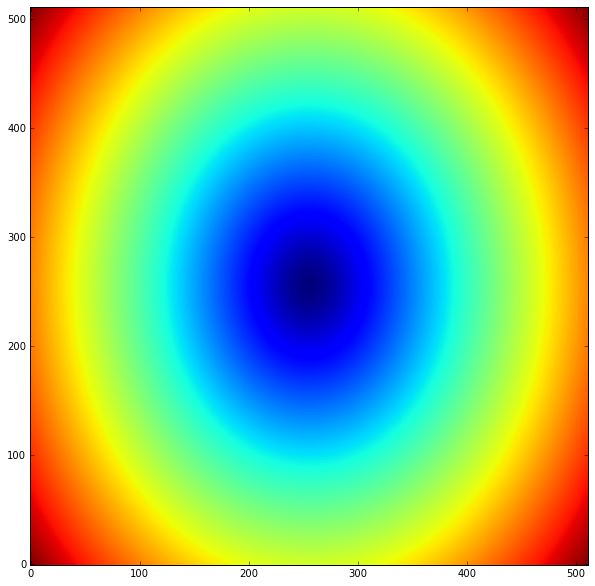

In [365]:
# step 1: build a potential map

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def psi_nie(xk,yk,f,xc):

    mappa=[]
    for i in range(xk.size):
        for j in range(yk.size):
            phi=np.arctan2(yk[j],xk[i])
            x=np.sqrt(xk[i]*xk[i]+yk[j]*yk[j])
            mappa.append(np.sqrt(xk[i]*xk[i]+f**2*yk[j]*yk[j]+xc*xc))
    mappa=np.array(mappa)
    mappa=mappa.reshape([xk.size,yk.size],order='F')

    return(np.abs(mappa))

f=0.8 # try also: 0.6, 0.4
xc=0.2
xmin=-3
xmax=3
ymin=-3
ymax=3
npix=512

xk=np.linspace(xmin,xmax,npix)
yk=np.linspace(ymin,ymax,npix)

psi=psi_nie(xk,yk,f,xc)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(psi,origin='low')

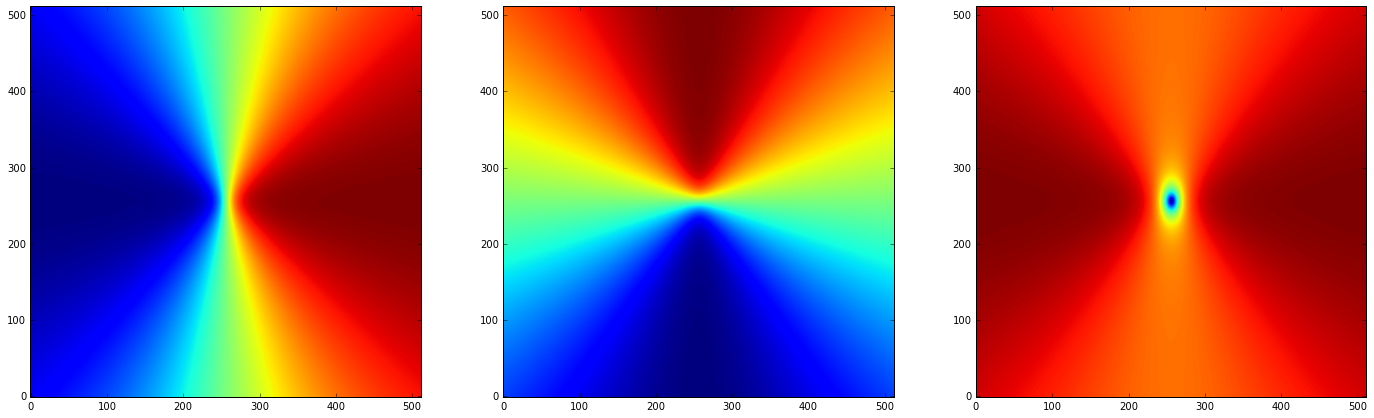

In [366]:
# step 2: from the potential to the deflection angle

dx=float(xmax-xmin)/(npix-1)
alpha2,alpha1=np.gradient(psi,dx,dx)
fig,ax=plt.subplots(1,3,figsize=(24,7))
ax[0].imshow(alpha1,origin='low')
ax[1].imshow(alpha2,origin='low')
ax[2].imshow(np.sqrt(alpha1*alpha1+alpha2*alpha2),origin='low')

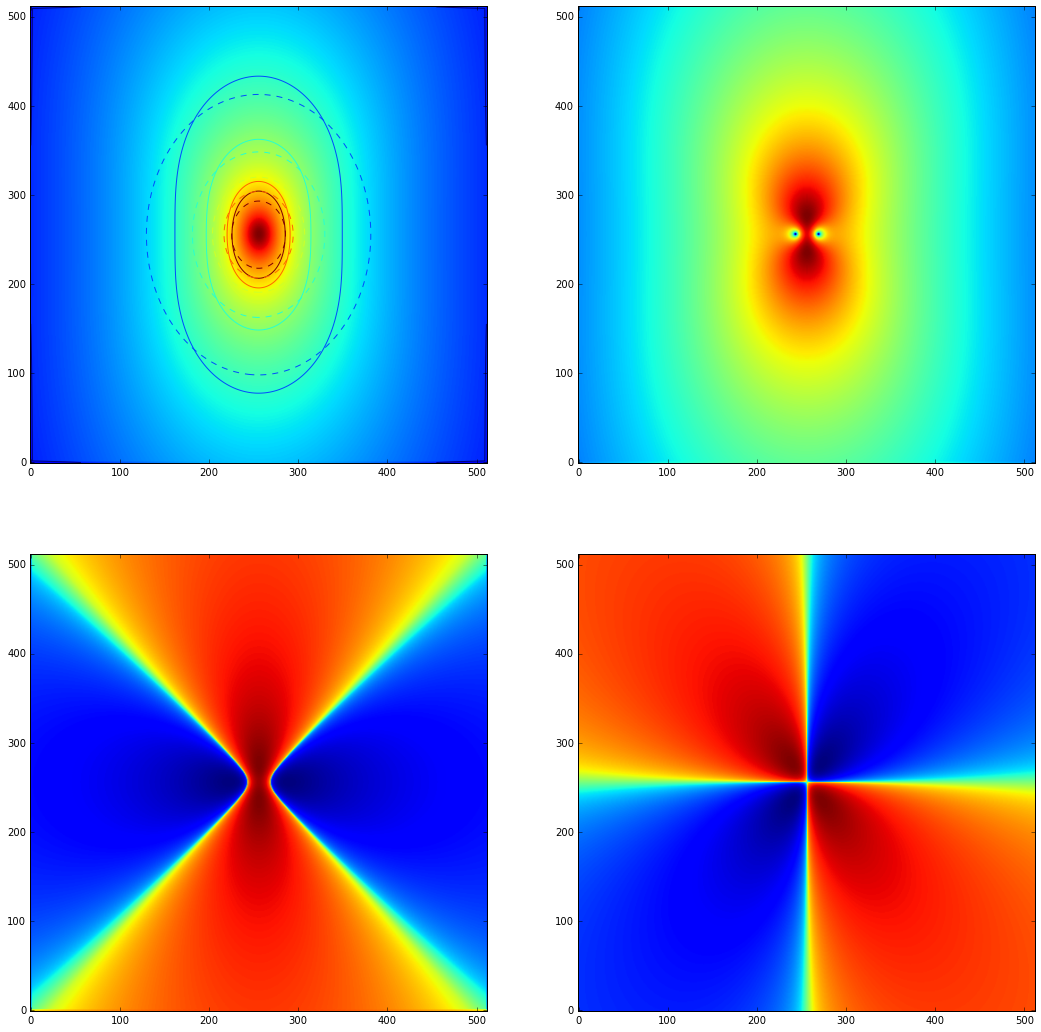

In [367]:
from matplotlib.colors import LogNorm, SymLogNorm

da1dx2,da1dx1=np.gradient(alpha1,dx,dx)
da2dx2,da2dx1=np.gradient(alpha2,dx,dx)

kappa=0.5*(da1dx1+da2dx2)
gamma1=0.5*(da1dx1-da2dx2)
gamma2=da1dx2


gamma=np.sqrt(gamma1*gamma1+gamma2*gamma2)

fig,ax=plt.subplots(2,2,figsize=(18,18))
ax[0,0].imshow(kappa,origin='low',norm=LogNorm())
cs=ax[0,0].contour(kappa,levels=[0.1,0.3,0.5,0.7,0.9,1.1])
ax[0,1].imshow(gamma,origin='low',norm=LogNorm())
ax[1,0].imshow(gamma1,origin='low',norm=SymLogNorm(linthresh=0.01))
ax[1,1].imshow(gamma2,origin='low',norm=SymLogNorm(linthresh=0.01))


########## compare to the NIE
def delta(f,phi):
    return np.sqrt(np.cos(phi)**2+f**2*np.sin(phi)**2)

def kappa_ell(x1,x2,f,xc):
    return(np.sqrt(f)/2.0/np.sqrt(x1**2+f**2*x2**2+xc**2))

def kappa_map(xk,yk,f):

    mappa=[]
    for i in range(xk.size):
        for j in range(yk.size):
            mappa.append(kappa_ell(xk[i],yk[j],f,xc))
    mappa=np.array(mappa)
    mappa=mappa.reshape([xk.size,yk.size],order='F')

    return(np.abs(mappa))

kappa_nie=kappa_map(xk,yk,f)
cs=ax[0,0].contour(kappa_nie,linestyles='dashed',levels=[0.1,0.3,0.5,0.7,0.9,1.1])

The upper left panel shows the convergence map of the pseudo elliptical lens, with overlaid some contours (solid lines). The dashed contours are the iso-convergence contours for the corresponding elliptical lens (the NIE studied in the past lesson). Note that 
* the NIE contours are rounder
* the NIE$_\psi$ contours are not elliptical!
* try out by increasing the ellipticity of the model (reduce $f$)...

Let see the critical lines:

(1, 625)
(1, 189)


(0, 512)

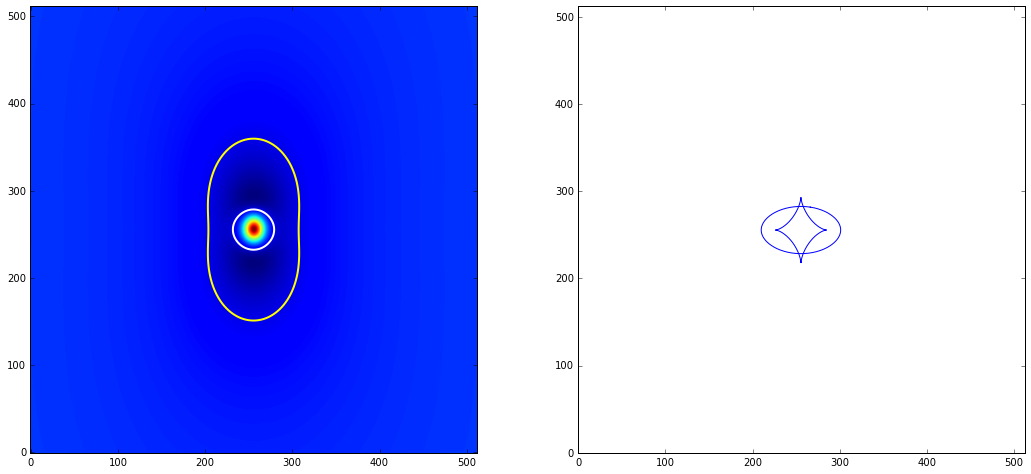

In [368]:
lambdat=1-kappa-gamma
lambdar=1-kappa+gamma
                   
            
fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].imshow((lambdat*lambdar),origin='low')
cst=ax[0].contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
ax[1].imshow(lambdar,origin='low',alpha=0)
csr=ax[0].contour(lambdar,levels=[0.0],colors='white',linewidths=2)

# caustics!
cs=ax[0].contour((lambdat*lambdar),levels=[0.0],alpha=0)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
        a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        print a1.shape
        
        # now we can make the mapping using the lens equation:
        y1=x1-a1[0]/(float(xmax-xmin)/npix)
        y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
        ax[1].plot(y1,y2,'-',color='blue')
        
ax[1].set_xlim([0,npix])
ax[1].set_ylim([0,npix])

63.2942695115 448.705730488 -3.0 3.0
51.2578431734 460.742156827 -3.0 3.0


(0, 512)

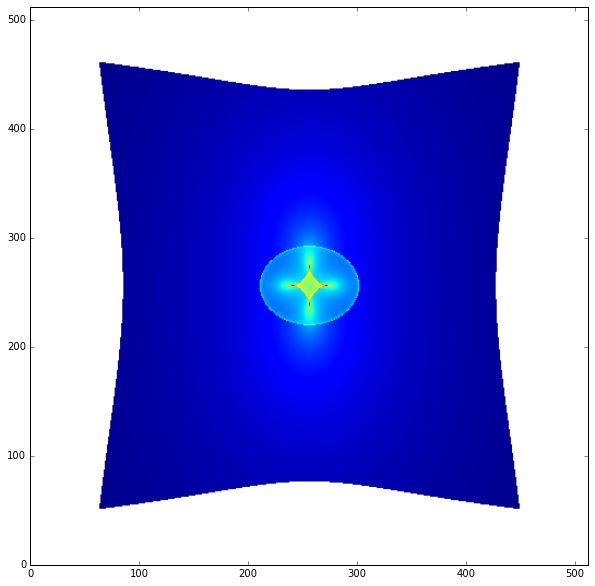

In [288]:
# the following code implements the algorithm described in Schneider, Ehlers & Falco 1992, page 300 -- 302
# to compute the magnification on the source plane

def mupds_map(xk,yk,alpha1,alpha2,lambdat,lambdar):
    deta=lambdar*lambdat
    mus=np.array(deta)
    for i in range(xk.size):
        for j in range(yk.size):
            mus[i,j]=0.0
    deray=1.0#xk[1]-xk[0]
    xcheck=np.zeros(4)
    ycheck=np.zeros(4)
    xray=[]
    yray=[]
    for i in range(xk.size):
        for j in range(yk.size):
            xray.append(xk[i]-alpha1[j,i])
            yray.append(yk[j]-alpha2[j,i])
    xray=np.array(xray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    yray=np.array(yray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    xray=xray.reshape([xk.size,yk.size],order='F')
    yray=yray.reshape([xk.size,yk.size],order='F')
    print np.amin(xray),np.amax(xray),np.amin(xk),np.amax(xk)
    print np.amin(yray),np.amax(yray),np.amin(yk),np.amax(yk)
    #ax.plot(xray,yray,',')
    #coordinates are now in pixels
    for i in range(xk.size-1):
        for j in range(yk.size-1):
            xcheck[0]=xray[i,j]
            xcheck[1]=xray[i+1,j]
            xcheck[2]=xray[i+1,j+1]
            xcheck[3]=xray[i,j+1]
            ycheck[0]=yray[i,j]
            ycheck[1]=yray[i+1,j]
            ycheck[2]=yray[i+1,j+1]
            ycheck[3]=yray[i,j+1]
            xmax=xcheck[0]
            xmin=xcheck[0]
            ymax=ycheck[0]
            ymin=ycheck[0]
            for k in range(1,xcheck.size):
                if (xcheck[k] > xmax):
                    xmax=xcheck[k]
                if (xcheck[k] < xmin):
                    xmin=xcheck[k]
                if (ycheck[k] > ymax):
                    ymax=ycheck[k]
                if (ycheck[k] < ymin):
                    ymin=ycheck[k]
            imax=np.int(np.int(xmax/deray)+1)
            imin=np.int(np.int(xmin/deray))
            jmax=np.int(np.int(ymax/deray)+1)
            jmin=np.int(np.int(ymin/deray))
            if (imin <0):
                imin=0
            if (jmin <0):
                jmin=0
            if (imax>xk.size):
                imax=xk.size
            if (jmax>yk.size):
                jmax=yk.size
            for ii in range(imin,imax):
                for jj in range(jmin,jmax):
                    x1=ii*deray-xray[i,j]
                    y1=jj*deray-yray[i,j]
                    x2=ii*deray-xray[i+1,j]
                    y2=jj*deray-yray[i+1,j]
                    x3=ii*deray-xray[i+1,j+1]
                    y3=jj*deray-yray[i+1,j+1]
                    x4=ii*deray-xray[i,j+1]
                    y4=jj*deray-yray[i,j+1]
                    prod12=x1*y2-x2*y1
                    prod23=x2*y3-x3*y2
                    prod31=x3*y1-x1*y3
                    prod13=-prod31
                    prod34=x3*y4-x4*y3
                    prod41=x4*y1-x1*y4
                    if (np.sign(prod12) == np.sign(prod23) and np.sign(prod23) == np.sign(prod31)):
                        dist2sum=(1./(x1**2+y1**2))+(1./(x2**2+y2**2))+(1./(x3**2+y3**2))
                        det1=np.abs(deta[i,j])
                        det2=np.abs(deta[i+1,j])
                        det3=np.abs(deta[i+1,j+1])
                        det_interp=((det1/(x1**2+y1**2))+(det2/(x2**2+y2**2))+(det3/(x3**2+y3**2)))/dist2sum
                        mu_interp=1./det_interp
                        mus[jj,ii]=mus[jj,ii]+mu_interp
                    elif (np.sign(prod13) == np.sign(prod34) and np.sign(prod34) == np.sign(prod41)):
                        dist2sum=(1./(x1**2+y1**2))+(1./(x3**2+y3**2))+(1./(x4**2+y4**2))
                        det1=np.abs(deta[i,j])
                        det2=np.abs(deta[i+1,j+1])
                        det3=np.abs(deta[i,j+1])
                        det_interp=((det1/(x1**2+y1**2))+(det2/(x3**2+y3**2))+(det3/(x4**2+y4**2)))/dist2sum
                        mu_interp=1./det_interp
                        mus[jj,ii]=mus[jj,ii]+mu_interp                        
    return(mus)




xkk=[]
ykk=[]
for i in range(xk.size):
    for j in range(yk.size):
        xkk.append(xk[i]-alpha1[j,i])
        ykk.append(yk[j]-alpha2[j,i])
        
fig,ax=plt.subplots(1,1,figsize=(10,10))
mus=mupds_map(xk,yk,alpha1,alpha2,lambdat,lambdar)
xkk=np.array(xkk)/2.0/np.amax(xk)*xk.size
ykk=np.array(ykk)/2.0/np.amax(xk)*xk.size
#ax.plot(xkk,ykk,',')
ax.imshow(mus,origin='low',norm=LogNorm())

overplotcaustics=False
if (overplotcaustics):

    icau=0
    if (sizevs.size > 0):
        for j in range(len(p)):
            # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
            vs = contour.get_paths()[j].vertices 
            sizevs[j]=len(vs)
            x1=[]
            x2=[]
            for i in range(len(vs)):
                xx1,xx2=vs[i]
                x1.append(float(xx1))
                x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
            a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
            a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
            y1=x1-a1[0]/(float(xmax-xmin)/npix)
            y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
            if (icau==0):
                ax.plot(y1,y2,'-',color='yellow',lw=2)
                icau=1
            else:
                ax.plot(y1,y2,'-',color='white',lw=2)
                
ax.set_xlim([0,xk.size])
ax.set_ylim([0,yk.size])

Note that when we map the whole lens plane onto the source plane, the area entering the FOV is actually smaller than that subtended by the lens plane. This is due to magnification! The main implication of this result is that when we look at the sky through a gravitational lens, whe are observing a smaller volume of the Universe compared to what we would see in absence of lensing. 
